# Poisson Regression for Competiton

In [1]:
# Import all packages that are required
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels
from patsy import dmatrices
from sklearn.metrics import mean_squared_error
import math
plt.style.use(['ggplot'])

In [2]:
# load the dataset
PATH = '/Users/dj/Documents/GitHub/Data/ts_forecast'
df = pd.read_csv( PATH + '/df.csv') # Training data 
df1 = pd.read_csv( PATH + '/df1.csv') # Testing data
df2 = pd.read_csv( PATH + '/df2.csv') # Complete data for Competition
reduced = pd.read_csv( PATH + '/reduced.csv') #Only last month
print(df.dtypes) # We can see that month is of type object, therefore it will be changed to datetime

Unnamed: 0     int64
d             object
date          object
weekday       object
id            object
sales          int64
dtype: object


In [3]:
# For some strange reason, a new column is being added which will be removed 
df = df.drop(['Unnamed: 0'], axis=1)
df1 = df1.drop(['Unnamed: 0'], axis=1)
df2 = df2.drop(['Unnamed: 0'], axis=1)
reduced = reduced.drop(['Unnamed: 0'], axis=1)

In [4]:
# Change the type object of date to date
df['date'] = pd.to_datetime(df['date'])
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
reduced['date'] = pd.to_datetime(reduced['date'])

print(df1.dtypes)

d                  object
date       datetime64[ns]
weekday            object
id                 object
sales               int64
dtype: object


In [5]:
df = df.sort_values(by = ['id', 'date'])
df1 = df1.sort_values(by = ['id', 'date'])
df2 = df2.sort_values(by = ['id', 'date'])
reduced = reduced.sort_values(by = ['id', 'date'])
df1

,d,date,weekday,id,sales
0,d_1914,2016-04-25,Monday,FOODS_3_001_TX_3_validation,1
1094,d_1915,2016-04-26,Tuesday,FOODS_3_001_TX_3_validation,0
2188,d_1916,2016-04-27,Wednesday,FOODS_3_001_TX_3_validation,0
3282,d_1917,2016-04-28,Thursday,FOODS_3_001_TX_3_validation,1
3310,d_1918,2016-04-29,Friday,FOODS_3_001_TX_3_validation,0
...,...,...,...,...,...
19733,d_1937,2016-05-18,Wednesday,FOODS_3_827_TX_3_validation,1
19761,d_1938,2016-05-19,Thursday,FOODS_3_827_TX_3_validation,0
20855,d_1939,2016-05-20,Friday,FOODS_3_827_TX_3_validation,4
21949,d_1940,2016-05-21,Saturday,FOODS_3_827_TX_3_validation,1


# End of Data Import - Let's do EDA

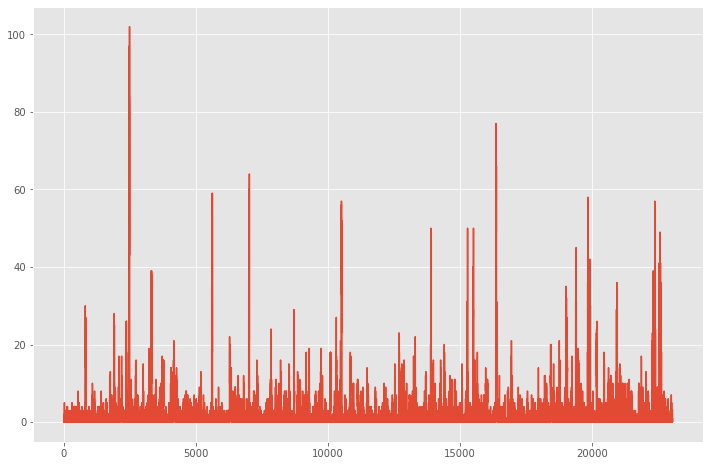

In [5]:
plt.figure(figsize=(12,8))
plt.plot(reduced["sales"])

# Creating a SMALL DATA FRAME for testing 



In [6]:
names = np.unique(df['id'])
selected = names[0:1]

small_df = df[df['id'].isin(selected)]
small_df = small_df.sort_values(by = ['id', 'date'])

In [7]:
small_ds = small_df['date']
small_df['MONTH'] = small_ds.dt.month
small_df['DAY_OF_WEEK'] = small_ds.dt.dayofweek
small_df['DAY'] = small_ds.dt.day

small_df

,d,date,weekday,id,sales,MONTH,DAY_OF_WEEK,DAY
0,d_1,2011-01-29,Saturday,FOODS_3_001_TX_3_validation,0,1,5,29
1093,d_2,2011-01-30,Sunday,FOODS_3_001_TX_3_validation,2,1,6,30
1945,d_3,2011-01-31,Monday,FOODS_3_001_TX_3_validation,1,1,0,31
2916,d_4,2011-02-01,Tuesday,FOODS_3_001_TX_3_validation,3,2,1,1
3565,d_5,2011-02-02,Wednesday,FOODS_3_001_TX_3_validation,0,2,2,2
...,...,...,...,...,...,...,...,...
1570915,d_1909,2016-04-20,Wednesday,FOODS_3_001_TX_3_validation,0,4,2,20
1571320,d_1910,2016-04-21,Thursday,FOODS_3_001_TX_3_validation,0,4,3,21
1572292,d_1911,2016-04-22,Friday,FOODS_3_001_TX_3_validation,5,4,4,22
1573265,d_1912,2016-04-23,Saturday,FOODS_3_001_TX_3_validation,2,4,5,23


In [16]:
piv_tab = small_df.pivot_table(index='date',columns='id',values='sales',aggfunc='sum')

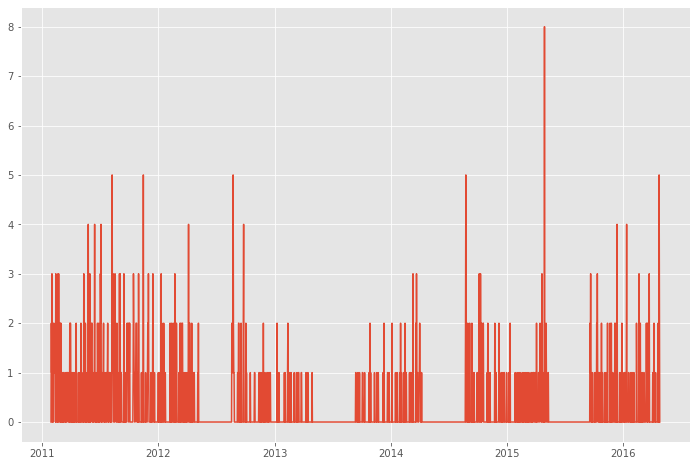

In [17]:
plt.figure(figsize=(12,8))
plt.plot(piv_tab)
plt.show()

In [15]:
small_r = df1[df1['id'].isin(selected)]
small_r = small_r.sort_values(by = ['id', 'date'])

small_dsr = small_r['date']
small_r['MONTH'] = small_dsr.dt.month
small_r['DAY_OF_WEEK'] = small_dsr.dt.dayofweek
small_r['DAY'] = small_dsr.dt.day
small_r

,d,date,weekday,id,sales,MONTH,DAY_OF_WEEK,DAY
0,d_1914,2016-04-25,Monday,FOODS_3_001_TX_3_validation,1,4,0,25
1094,d_1915,2016-04-26,Tuesday,FOODS_3_001_TX_3_validation,0,4,1,26
2188,d_1916,2016-04-27,Wednesday,FOODS_3_001_TX_3_validation,0,4,2,27
3282,d_1917,2016-04-28,Thursday,FOODS_3_001_TX_3_validation,1,4,3,28
3310,d_1918,2016-04-29,Friday,FOODS_3_001_TX_3_validation,0,4,4,29
4378,d_1919,2016-04-30,Saturday,FOODS_3_001_TX_3_validation,1,4,5,30
5472,d_1920,2016-05-01,Sunday,FOODS_3_001_TX_3_validation,0,5,6,1
6566,d_1921,2016-05-02,Monday,FOODS_3_001_TX_3_validation,0,5,0,2
6594,d_1922,2016-05-03,Tuesday,FOODS_3_001_TX_3_validation,0,5,1,3
7662,d_1923,2016-05-04,Wednesday,FOODS_3_001_TX_3_validation,0,5,2,4


# Transition to Poisson Regression

In [16]:
# Getting some additional data for the regression
ds = df['date']
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day


ds1 = df1['date']
df1['MONTH'] = ds.dt.month
df1['DAY_OF_WEEK'] = ds1.dt.dayofweek
df1['DAY'] = ds1.dt.day

ds2 = df2['date']
df2['MONTH'] = ds2.dt.month
df2['DAY_OF_WEEK'] = ds2.dt.dayofweek
df2['DAY'] = ds2.dt.day

rds = reduced['date']
reduced['MONTH'] = rds.dt.month
reduced['DAY_OF_WEEK'] = rds.dt.dayofweek
reduced['DAY'] = rds.dt.day

# Poisson Regression 

In [17]:
# old way
#mask = np.random.rand(len(small_df)) < 0.8
#df_train = small_df[mask]
#df_test = small_df[~mask]

# New way

df_train = small_df
df_test = small_r
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=1913
Testing data set length=28


In [27]:
expr = """sales ~ DAY +  MONTH + weekday"""

In [28]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [29]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [30]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  sales   No. Observations:                 1913
Model:                            GLM   Df Residuals:                     1904
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1467.9
Date:                Sun, 12 Dec 2021   Deviance:                       1969.7
Time:                        11:57:51   Pearson chi2:                 2.97e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02903
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.0381 

In [22]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

           mean   mean_se  mean_ci_lower  mean_ci_upper
0      0.329359  0.021172       0.290371       0.373583
1094   0.328429  0.022150       0.287763       0.374842
2188   0.327501  0.023172       0.285094       0.376216
3282   0.326576  0.024230       0.282378       0.377692
3310   0.325653  0.025319       0.279625       0.379258
4378   0.324733  0.026434       0.276846       0.380904
5472   0.347651  0.027144       0.298320       0.405140
6566   0.346669  0.025757       0.299690       0.401013
6594   0.345690  0.024408       0.301013       0.396998
7662   0.344713  0.023103       0.302280       0.393104
8756   0.343739  0.021848       0.303478       0.389342
9850   0.342768  0.020648       0.304596       0.385724
9878   0.341800  0.019513       0.305617       0.382267
10946  0.340834  0.018452       0.306522       0.378988
12040  0.339872  0.017476       0.307289       0.375909
13134  0.338911  0.016597       0.307894       0.373053
13189  0.337954  0.015829       0.308311       0

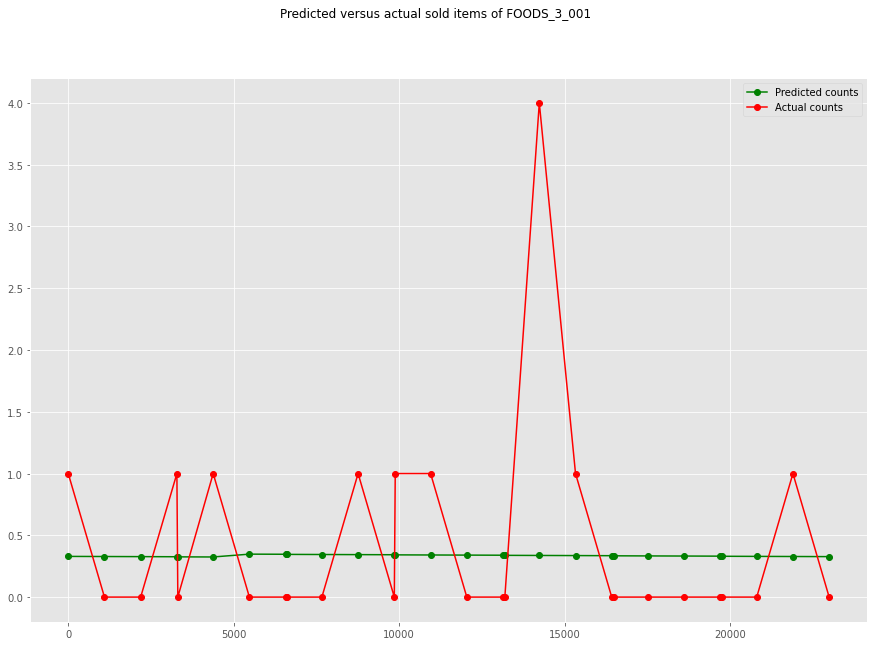

In [23]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['sales']
fig = plt.figure(figsize=(15,10))
fig.suptitle('Predicted versus actual sold items of FOODS_3_001')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()


<Figure size 432x288 with 0 Axes>

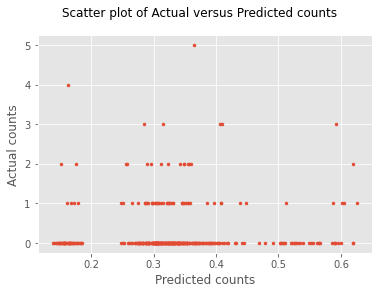

In [17]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

In [18]:
np.mean(y_test['sales'])

0.28184281842818426

In [38]:
pred = predictions_summary_frame['mean']
print(len(pred))
print(len(y_test))
test = np.array(y_test).reshape(369,).shape

369
369


In [40]:
rmse = statsmodels.tools.eval_measures.rmse(pred, test, axis = 0)

In [62]:
rmse

368.6706400890091

# FOR LOOP FOR MULTIVARIATE FORECAST AND RMSE

In [43]:
names = np.unique(df['id'])

f = []
for i in np.arange(1,29):
    f.append('F' + str(i))

r = np.arange(28)

z = pd.Series(np.zeros(28))

d = {'mean': z}
forecasts = pd.DataFrame(d)

rmse_list = []

In [44]:
# get data ready
# selected = names[0:2]
# zip_object = zip(selected, r)

for i in names:

    small_df = df[df['id'].isin([i])]
    small_df = small_df.sort_values(by = ['id', 'date'])

    small_r = df1[df1['id'].isin([i])]
    small_r = small_r.sort_values(by = ['id', 'date'])

    small_ds = small_df['date']
    small_df['MONTH'] = small_ds.dt.month
    small_df['DAY_OF_WEEK'] = small_ds.dt.dayofweek
    small_df['DAY'] = small_ds.dt.day

    small_dsr = small_r['date']
    small_r['MONTH'] = small_dsr.dt.month
    small_r['DAY_OF_WEEK'] = small_dsr.dt.dayofweek
    small_r['DAY'] = small_dsr.dt.day

    # Begin Regression
    expr = """sales ~ DAY +  MONTH + weekday"""

    df_train = small_df
    df_test = small_r
    
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    
    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

    poisson_predictions = poisson_training_results.get_prediction(X_test)
    #summary_frame() returns a pandas DataFrame
    predictions_summary_frame = poisson_predictions.summary_frame()
    p = predictions_summary_frame['mean']
    forecasts[i] = np.array(p).reshape(28,1)

    # RMSE
    MSE = mean_squared_error(y_test, p)
    RMSE = math.sqrt(MSE)
    rmse_list.append(RMSE)

/opt/anaconda3/envs/python_env_37/lib/python3.7/site-packages/ipykernel_launcher.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/anaconda3/envs/python_env_37/lib/python3.7/site-packages/ipykernel_launcher.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/anaconda3/envs/python_env_37/lib/python3.7/site-packages/ipykernel_launcher.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

In [45]:
forecasts

,mean,FOODS_3_001_TX_3_validation,FOODS_3_002_TX_3_validation,FOODS_3_003_TX_3_validation,FOODS_3_004_TX_3_validation,FOODS_3_005_TX_3_validation,FOODS_3_006_TX_3_validation,FOODS_3_007_TX_3_validation,FOODS_3_008_TX_3_validation,FOODS_3_009_TX_3_validation,...,FOODS_3_818_TX_3_validation,FOODS_3_819_TX_3_validation,FOODS_3_820_TX_3_validation,FOODS_3_821_TX_3_validation,FOODS_3_822_TX_3_validation,FOODS_3_823_TX_3_validation,FOODS_3_824_TX_3_validation,FOODS_3_825_TX_3_validation,FOODS_3_826_TX_3_validation,FOODS_3_827_TX_3_validation
0,0.0,0.298776,0.774437,0.140210,0.050108,0.770244,0.306746,4.589654,1.350888,0.172601,...,1.493126,1.144954,1.102125,0.152295,2.671546,0.154722,0.196292,0.682184,0.552432,0.345600
1,0.0,0.511016,0.639666,0.144363,0.095236,0.640477,0.324969,4.027236,0.894110,0.153421,...,1.470693,1.002107,1.108068,0.243645,2.457232,0.136906,0.220131,0.580506,0.624541,0.285908
2,0.0,0.176003,0.652244,0.134853,0.068081,0.563828,0.208365,3.501393,0.868928,0.171742,...,1.766846,0.836181,1.269548,0.311884,2.178674,0.153653,0.184875,0.472353,0.604115,0.338644
3,0.0,0.303562,0.540911,0.143233,0.064041,0.622597,0.279311,4.442033,0.921636,0.178817,...,1.098453,1.021182,1.090816,0.222077,2.389490,0.126575,0.212528,0.525771,0.591473,0.294577
4,0.0,0.309904,0.552676,0.111611,0.063026,0.596657,0.257340,3.739869,0.981393,0.234085,...,1.062396,0.891562,1.103745,0.362982,2.656481,0.150063,0.236410,0.479453,0.613267,0.396192
5,0.0,0.286376,0.672000,0.137764,0.099344,0.745259,0.220031,5.507204,1.016530,0.158931,...,1.514588,1.178555,1.420242,0.395192,3.625062,0.154569,0.318351,0.659439,0.701943,0.443837
6,0.0,0.432586,1.006381,0.181404,0.113754,0.966299,0.645773,7.543545,1.294422,0.189108,...,1.495020,1.914081,1.275146,0.473816,3.064363,0.348099,0.262999,0.879020,0.658435,0.506983
7,0.0,0.313385,1.008205,0.125846,0.067679,0.977281,0.562357,6.679713,1.279131,0.177953,...,1.535229,1.706222,1.153994,0.134111,2.500928,0.253345,0.186266,0.840377,0.555708,0.320353
8,0.0,0.536003,0.832753,0.129574,0.128633,0.812633,0.595765,5.861179,0.846616,0.158178,...,1.512163,1.493349,1.160217,0.214554,2.300301,0.224173,0.208887,0.715122,0.628245,0.265022
9,0.0,0.184609,0.849127,0.121038,0.091955,0.715381,0.381995,5.095874,0.822773,0.177067,...,1.816667,1.246085,1.329296,0.274645,2.039533,0.251594,0.175432,0.581889,0.607697,0.313905


In [46]:
np.mean(rmse_list)

2.084263380672504

In [68]:
forecasts = forecasts.drop(['mean'], axis=1)

In [69]:
# forecasts.set_index('F')

In [70]:
competition = forecasts.T

In [71]:
competition.columns = f

In [72]:
competition

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
FOODS_3_001_TX_3_validation,0.331501,0.330606,0.329713,0.328823,0.327935,0.327050,0.348668,0.347726,0.346787,0.345851,...,0.337538,0.336626,0.335718,0.334811,0.333907,0.333006,0.332107,0.331210,0.330316,0.329424
FOODS_3_002_TX_3_validation,0.672763,0.664206,0.655758,0.647417,0.639182,0.631052,0.899208,0.887771,0.876479,0.865330,...,0.771165,0.761357,0.751673,0.742112,0.732673,0.723353,0.714153,0.705069,0.696101,0.687247
FOODS_3_003_TX_3_validation,0.151903,0.151240,0.150580,0.149923,0.149269,0.148618,0.145170,0.144537,0.143906,0.143278,...,0.137749,0.137148,0.136550,0.135954,0.135361,0.134770,0.134182,0.133597,0.133014,0.132434
FOODS_3_004_TX_3_validation,0.078219,0.077104,0.076004,0.074921,0.073853,0.072800,0.108110,0.106569,0.105049,0.103552,...,0.090998,0.089700,0.088421,0.087161,0.085918,0.084693,0.083486,0.082296,0.081122,0.079966
FOODS_3_005_TX_3_validation,0.698169,0.690724,0.683359,0.676072,0.668862,0.661730,0.904312,0.894669,0.885128,0.875690,...,0.795146,0.786667,0.778278,0.769979,0.761768,0.753645,0.745609,0.737658,0.729792,0.722010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_TX_3_validation,0.164424,0.161073,0.157791,0.154575,0.151425,0.148339,0.273188,0.267621,0.262167,0.256825,...,0.213385,0.209036,0.204777,0.200604,0.196516,0.192511,0.188588,0.184745,0.180980,0.177292
FOODS_3_824_TX_3_validation,0.235131,0.235274,0.235418,0.235561,0.235705,0.235849,0.225564,0.225701,0.225839,0.225977,...,0.227220,0.227359,0.227497,0.227636,0.227775,0.227914,0.228053,0.228192,0.228331,0.228470
FOODS_3_825_TX_3_validation,0.609942,0.603962,0.598042,0.592179,0.586374,0.580626,0.754376,0.746981,0.739659,0.732408,...,0.670267,0.663697,0.657191,0.650748,0.644369,0.638052,0.631798,0.625604,0.619471,0.613399
FOODS_3_826_TX_3_validation,0.640753,0.639431,0.638112,0.636796,0.635482,0.634171,0.651005,0.649662,0.648322,0.646984,...,0.635070,0.633760,0.632452,0.631147,0.629845,0.628546,0.627249,0.625955,0.624664,0.623375


In [73]:
competition.to_csv(PATH + '/poisson_pred.csv', index=True) # Save it for kaggle competition

# Little input on how to create a zip objects

In [158]:
selected = names[0:3]
zip_object = zip(selected, f)

for i,j in zip_object:
    print(i,j)

FOODS_3_001_TX_3_validation F1
FOODS_3_002_TX_3_validation F2
FOODS_3_003_TX_3_validation F3


# Multivariate forecast for competition

In [65]:
names = np.unique(df['id'])

f = []
for i in np.arange(1,29):
    f.append('F' + str(i))

r = np.arange(28)

z = pd.Series(np.zeros(28))

d = {'mean': z}
forecasts = pd.DataFrame(d)

In [66]:
# get data ready
selected = names[0:5]
# zip_object = zip(selected, r)

for i in names:

    small_df = df2[df2['id'].isin([i])]
    small_df = small_df.sort_values(by = ['id', 'date'])

    small_r = df1[df1['id'].isin([i])]
    small_r = small_r.sort_values(by = ['id', 'date'])

    small_ds = small_df['date']
    small_df['MONTH'] = small_ds.dt.month
    small_df['DAY_OF_WEEK'] = small_ds.dt.dayofweek
    small_df['DAY'] = small_ds.dt.day

    small_dsr = small_r['date']
    small_r['MONTH'] = small_dsr.dt.month
    small_r['DAY_OF_WEEK'] = small_dsr.dt.dayofweek
    small_r['DAY'] = small_dsr.dt.day

    # Begin Regression
    expr = """sales ~ DAY +  MONTH"""

    df_train = small_df
    df_test = small_r
    
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    
    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

    poisson_predictions = poisson_training_results.get_prediction(X_test)
    #summary_frame() returns a pandas DataFrame
    predictions_summary_frame = poisson_predictions.summary_frame()

    p = predictions_summary_frame['mean']

    forecasts[i] = np.array(p).reshape(28,1)

/opt/anaconda3/envs/python_env_37/lib/python3.7/site-packages/ipykernel_launcher.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [67]:
forecasts

,mean,FOODS_3_001_TX_3_validation,FOODS_3_002_TX_3_validation,FOODS_3_003_TX_3_validation,FOODS_3_004_TX_3_validation,FOODS_3_005_TX_3_validation,FOODS_3_006_TX_3_validation,FOODS_3_007_TX_3_validation,FOODS_3_008_TX_3_validation,FOODS_3_009_TX_3_validation,...,FOODS_3_818_TX_3_validation,FOODS_3_819_TX_3_validation,FOODS_3_820_TX_3_validation,FOODS_3_821_TX_3_validation,FOODS_3_822_TX_3_validation,FOODS_3_823_TX_3_validation,FOODS_3_824_TX_3_validation,FOODS_3_825_TX_3_validation,FOODS_3_826_TX_3_validation,FOODS_3_827_TX_3_validation
0,0.0,0.331501,0.672763,0.151903,0.078219,0.698169,0.302902,4.544287,1.160944,0.192992,...,1.424598,1.083523,1.207309,0.321549,2.718799,0.164424,0.235131,0.609942,0.640753,0.407997
1,0.0,0.330606,0.664206,0.151240,0.077104,0.690724,0.294311,4.480724,1.169184,0.192669,...,1.423713,1.064695,1.206818,0.323110,2.726427,0.161073,0.235274,0.603962,0.639431,0.408915
2,0.0,0.329713,0.655758,0.150580,0.076004,0.683359,0.285963,4.418051,1.177484,0.192348,...,1.422828,1.046195,1.206327,0.324679,2.734077,0.157791,0.235418,0.598042,0.638112,0.409835
3,0.0,0.328823,0.647417,0.149923,0.074921,0.676072,0.277852,4.356254,1.185842,0.192026,...,1.421945,1.028016,1.205836,0.326255,2.741749,0.154575,0.235561,0.592179,0.636796,0.410757
4,0.0,0.327935,0.639182,0.149269,0.073853,0.668862,0.269971,4.295321,1.194260,0.191706,...,1.421061,1.010153,1.205345,0.327839,2.749442,0.151425,0.235705,0.586374,0.635482,0.411681
5,0.0,0.327050,0.631052,0.148618,0.072800,0.661730,0.262313,4.235241,1.202737,0.191386,...,1.420179,0.992600,1.204855,0.329431,2.757157,0.148339,0.235849,0.580626,0.634171,0.412607
6,0.0,0.348668,0.899208,0.145170,0.108110,0.904312,0.583663,6.747013,1.052146,0.195859,...,1.461449,1.626749,1.254356,0.283476,2.538815,0.273188,0.225564,0.754376,0.651005,0.370810
7,0.0,0.347726,0.887771,0.144537,0.106569,0.894669,0.567108,6.652640,1.059615,0.195532,...,1.460541,1.598483,1.253846,0.284852,2.545938,0.267621,0.225701,0.746981,0.649662,0.371644
8,0.0,0.346787,0.876479,0.143906,0.105049,0.885128,0.551022,6.559587,1.067136,0.195205,...,1.459634,1.570707,1.253336,0.286235,2.553082,0.262167,0.225839,0.739659,0.648322,0.372480
9,0.0,0.345851,0.865330,0.143278,0.103552,0.875690,0.535393,6.467836,1.074711,0.194880,...,1.458728,1.543414,1.252825,0.287625,2.560246,0.256825,0.225977,0.732408,0.646984,0.373318
